# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2019-2020 учебный год

Илья Щуров, Соня Дымченко, Руслан Хайдуров, Александр Каган, Павел Балтабаев

# Семинар 13


На этом семинаре мы:

- поработаем с изображениями с помощью нейронных сетей

- опробуем два разных вида регуляризации - Dropout и l2

- напишем несколько классификаторов для MNIST и сравним качество MLP и CNN

- решим задачу бинарной классификации с помощью fine-tuning предобученной модели

In [ ]:
# install torch if you use linux and pip like this
# otherwise see: https://pytorch.org/get-started/locally/
! pip3 install torch torchvision

# Регуляризация

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

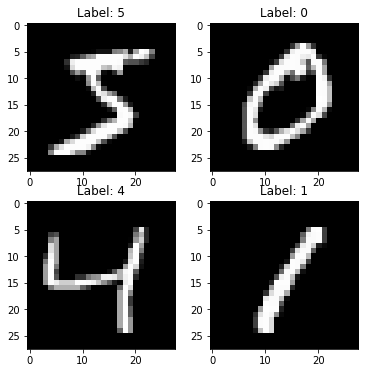

In [2]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [3]:
nn.Module

torch.nn.modules.module.Module

In [4]:
from util import iterate_minibatches

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
            data = torch.from_numpy(x_batch.astype(np.float32))
            target = torch.from_numpy(y_batch.astype(np.int64))

            output = model(data)
            loss = F.nll_loss(output, target)

            pred = torch.max(output, 1)[1].numpy()
            acc = np.mean(pred == y_batch)
            acc_log.append(acc)

            loss = loss.item()
            loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(15, 4))
    plt.title('{}'.format(title))
    
    points = np.array(train_history)
    plt.plot(points[:,0], points[:,1], label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)
        steps = len(X_train) / batchsize
        train_log.append((steps * (epoch + 1), np.mean(train_loss)))
        train_acc_log.append((steps * (epoch + 1), np.mean(train_acc)))

        
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

Обучите простейшую нейронную сеть - однослойный перцептрон.

In [5]:
input_size = 784
num_classes = 10
batch_size = 128

In [6]:
model = nn.Sequential(
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(-1)
    # (つ▀¯▀)つ
    )

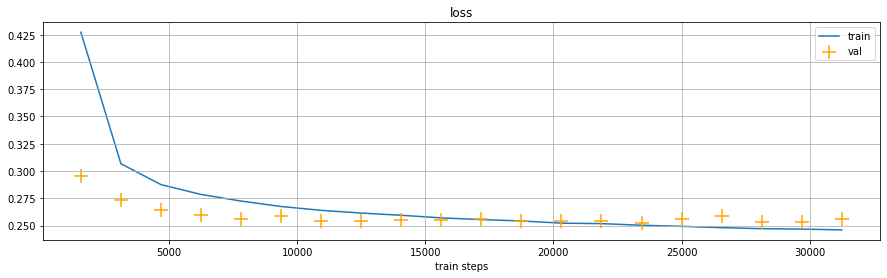

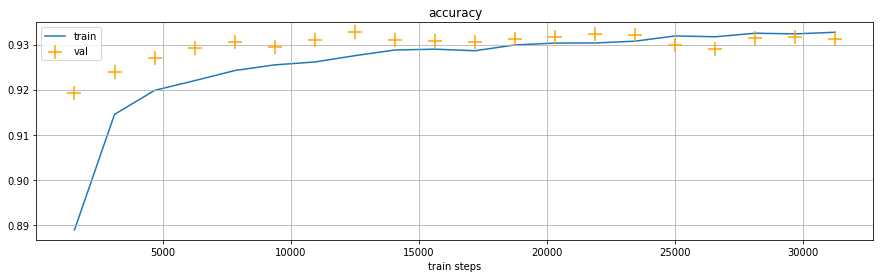

Final error: 6.87%


In [7]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train(model, opt, 20)

Что является гиперпараметрами алгоритма? Визуализируйте соответствующие наборы найденных при обучении гиперпараметров для каждого класса.

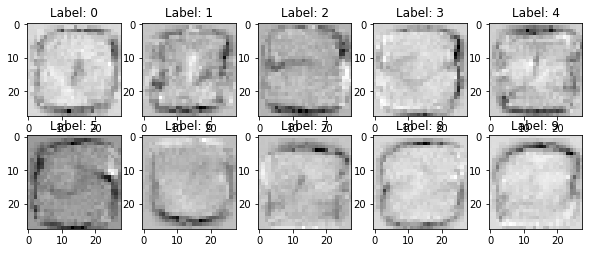

In [8]:
weights = list(model.parameters())[0].detach().numpy() # (つ▀¯▀)つ
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray')

Добавьте слой Dropout в архитектуру сети. Есть ли разница между весами, обученными с Dropout и без него?

In [9]:
nn.Dropout?

In [10]:
modelDp = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(-1)
    # (つ▀¯▀)つ
    )

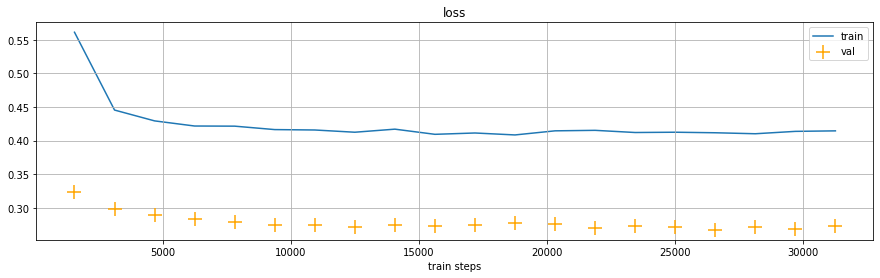

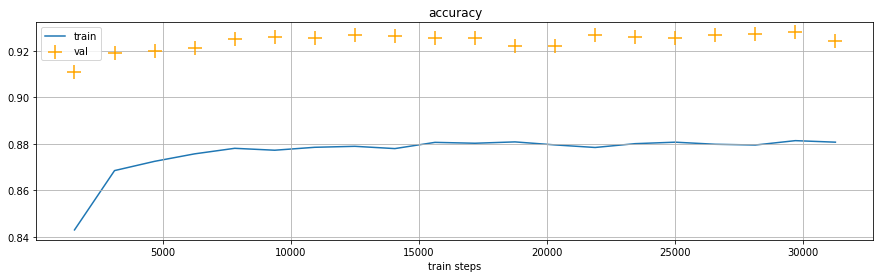

Final error: 7.56%


In [11]:
opt = torch.optim.RMSprop(modelDp.parameters(), lr=0.001)
train(modelDp, opt, 20)

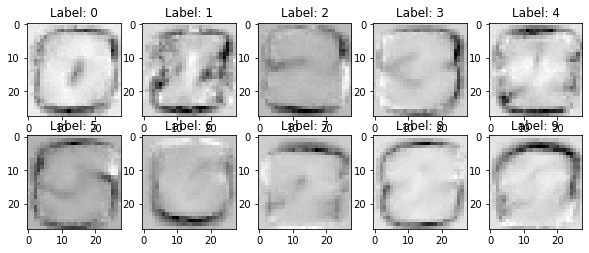

In [12]:
weights = list(modelDp.parameters())[0].detach().numpy() # (つ▀¯▀)つ
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray')

Теперь используйте l2-регуляризацию (за это отвечает параметр `weight_decay` в оптимизаторе) вместо Dropout и сравните полученные веса с двумя предыдущими результатами.

In [13]:
model_reg = nn.Sequential(    
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(-1)
    # (つ▀¯▀)つ
    )

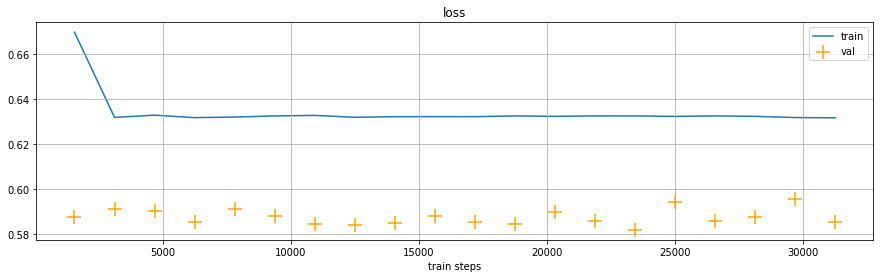

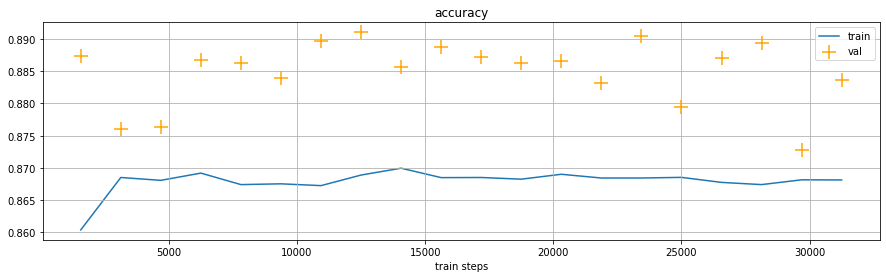

Final error: 11.64%


In [14]:
opt = torch.optim.RMSprop(model_reg.parameters(), lr=0.001, weight_decay=0.05)
train(model_reg, opt, 20)

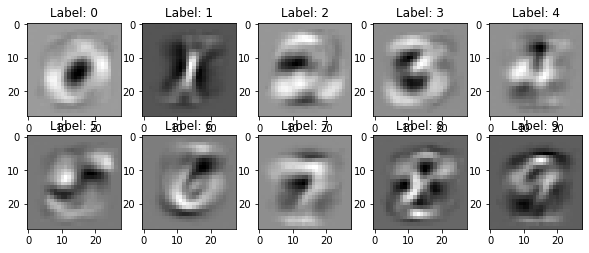

In [15]:
weights = list(model_reg.parameters())[0].detach().numpy()# (つ▀¯▀)つ
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray')

# MLP vs CNN

Обучите трехслойную полносвязную сеть с нелинейной функции активации (например, ReLU).

In [16]:
hidden_size = 256

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes),
    nn.LogSoftmax(-1)
    # (つ▀¯▀)つ
    )

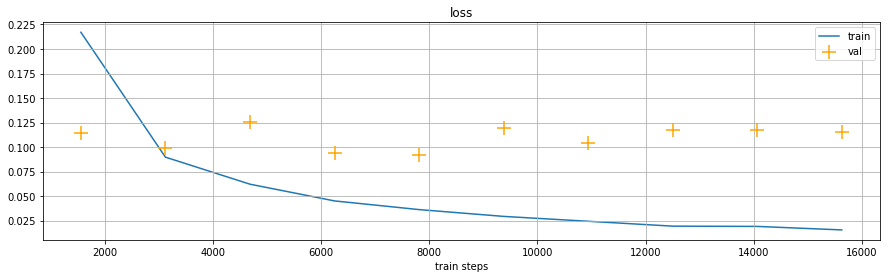

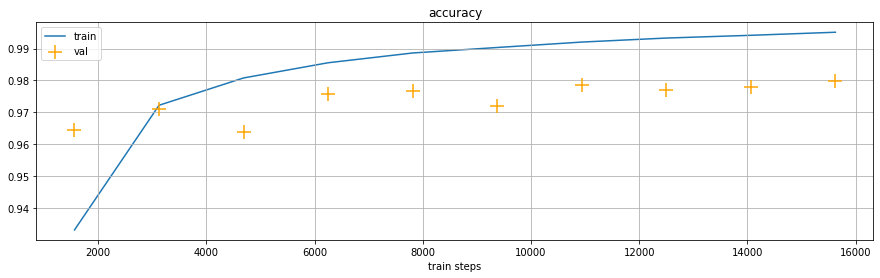

Final error: 2.02%


In [17]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 10)

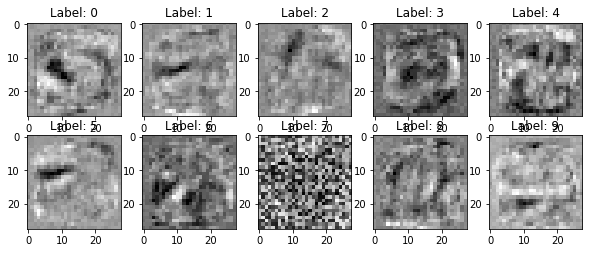

In [18]:
weights = list(model.parameters())[0].detach().numpy() # (つ▀¯▀)つ
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray')

Реализуйте сверточную сеть, которая состоит из двух последовательных применений свертки, relu и max-пулинга, а потом полносвязного слоя. Подберите параметры так, чтобы на выходе последнего слоя размерность тензора была 4 x 4 x 16. Сравните результат с предыдущим подходом.

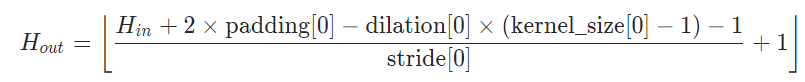

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=4, padding=1, stride=2)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=3, padding=1, stride=2)        
        self.classifier = nn.Linear(4 * 4 * 16, 10)
        
    def forward(self, x):
#         print(x.shape)
        x = x.reshape(-1, 1, 28, 28)
        x = self.pool(self.act(self.conv1(x)))
        x = self.act(self.conv2(x))
#         print(x.shape)
        x = x.reshape(-1, 4*4*16)        
        out = self.classifier(x)
#         print(out.shape)
        # (つ▀¯▀)つ
        return F.log_softmax(out, dim=-1)

In [20]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 3230


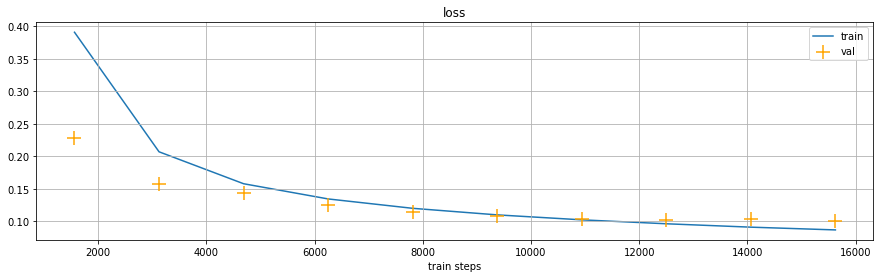

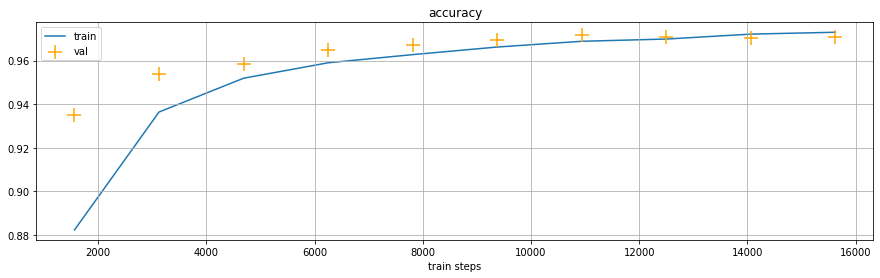

Final error: 2.92%
CPU times: user 12min 49s, sys: 22.8 s, total: 13min 12s
Wall time: 2min 14s


In [21]:
%%time

opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 10)

# Fine-tuning

Потребуется установить пакет `torchvision`:

```
pip install torchvision
```

Для многих прикладных задач не существует больших датасетов с хорошей разметкой. 
Поэтому распространенным приемом является тренировка на похожем, но большом датасете и доучивание сети на целевом.

Такой прием называют **Transfer Learning** или **Fine-tuning**.

В сверточных сетях для классификации выделяют две части:
- тело сети - это набор сверток и пулингов (convolutions and poolings)
- голову - это MLP (набор полносвязных слоев), после которых делается softmax и получаются вероятности разных классов.


Вычислительно простым вариантом finetuning является переучивание головы сети.


Нам потребуется предобученная модель и датасет для нашей задачи.

Предлагется воспользоваться моделью для ImageNet и датасетом  https://download.pytorch.org/tutorial/hymenoptera_data.zip


В датасете содержатся картинки двух классов (`ants` и `bees`) разных размеров.

Загрузчик данных -- одна из важных компонент для эффективного обучения нейронных сетей:
асинхронная загрузка и быстрая предобработка важны для полного использования GPU.

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [ ]:
!unzip hymenoptera_data.zip

In [22]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

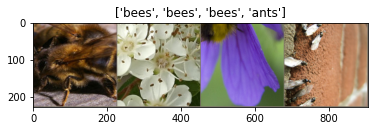

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
# обратите внимание на сохранение лучшей версии весов сети
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
# torchvision содержит ряд моделей с предобученными весами:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'video',
 'wide_resnet101_2',
 'wide_resnet50_2']

Используйте предобученную модель ResNet18. Замените в ней последний слой для того, чтобы она работала для двух классов, и дообучите только его, а остальные параметры оставьте как есть.

In [26]:
model_ft = models.resnet18(pretrained=True)

# Список слоев модели можно получить с помощью обхода
for x in model_ft.named_modules():
    print(x[0], x[1])

for params in model_ft.parameters():
    params.requires_grad = False

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [30]:
# TODO: замените в модели последний слой, чтобы она работала для двух классов
# (つ▀¯▀)つ
model_ft.fc = nn.Linear(512, 2)

In [31]:
# TODO: выберите, какие параметры дообучать
params_to_train = model_ft.fc.parameters() # (つ▀¯▀)つ


# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [32]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)
# если все сделано правильно, то точность на валидации должна быть больше 94%

Epoch 0/4
----------


/home/svdcvt/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1298 Acc: 0.7459
val Loss: 0.0776 Acc: 0.8758
Elapsed 0m 28s

Epoch 1/4
----------
train Loss: 0.1271 Acc: 0.7500
val Loss: 0.0606 Acc: 0.9216
Elapsed 0m 55s

Epoch 2/4
----------
train Loss: 0.1238 Acc: 0.7910
val Loss: 0.0710 Acc: 0.8954
Elapsed 1m 26s

Epoch 3/4
----------
train Loss: 0.0934 Acc: 0.8402
val Loss: 0.0557 Acc: 0.9346
Elapsed 2m 4s

Epoch 4/4
----------
train Loss: 0.0823 Acc: 0.8525
val Loss: 0.0461 Acc: 0.9412
Elapsed 2m 40s

Training complete in 2m 40s
Best val Acc: 0.941176


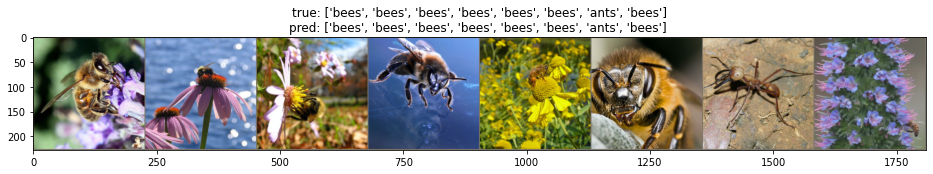

In [33]:
# TODO: напишите функцию, прогоняющую модель на нескольких примерах из валидационной выборки
# Отобразите картинки и предсказания

def visualize(model, num_images=10):
    # Get a batch of training data
    inputs, classes = next(iter(torch.utils.data.DataLoader(image_datasets['val'], batch_size=num_images,
                                             shuffle=True, num_workers=4)))
    
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    # (つ▀¯▀)つ
    preds = model(inputs)
    imshow(out, title=f'true: {[class_names[x] for x in classes]}\n'
                      f'pred: {[class_names[x] for x in preds.argmax(-1)]} ')

plt.figure(figsize=(16,9))
visualize(model_ft, 8)

Теперь попробуйте дообучить все слои исходной сети и сравните этот подход с предыдущим. Результат получается лучше если дообучать все или только последний слой? Почему?

In [36]:
model_ft = models.resnet18(pretrained=True)
model_ft.fc = nn.Linear(512, 2)

params_to_train = model_ft.parameters()

# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [37]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/home/svdcvt/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1556 Acc: 0.6762
val Loss: 0.0427 Acc: 0.9346
Elapsed 0m 53s

Epoch 1/9
----------
train Loss: 0.1323 Acc: 0.7582
val Loss: 0.0776 Acc: 0.8758
Elapsed 2m 5s

Epoch 2/9
----------
train Loss: 0.1805 Acc: 0.7582
val Loss: 0.1050 Acc: 0.8497
Elapsed 3m 5s

Epoch 3/9
----------
train Loss: 0.1341 Acc: 0.7992
val Loss: 0.0399 Acc: 0.9346
Elapsed 4m 4s

Epoch 4/9
----------
train Loss: 0.1209 Acc: 0.8074
val Loss: 0.0364 Acc: 0.9542
Elapsed 5m 3s

Epoch 5/9
----------
train Loss: 0.0986 Acc: 0.8197
val Loss: 0.0351 Acc: 0.9412
Elapsed 6m 3s

Epoch 6/9
----------
train Loss: 0.0613 Acc: 0.9098
val Loss: 0.0431 Acc: 0.9281
Elapsed 6m 54s

Epoch 7/9
----------
train Loss: 0.0773 Acc: 0.8402
val Loss: 0.0368 Acc: 0.9346
Elapsed 7m 46s

Epoch 8/9
----------
train Loss: 0.0632 Acc: 0.9139
val Loss: 0.0368 Acc: 0.9216
Elapsed 8m 41s

Epoch 9/9
----------
train Loss: 0.0737 Acc: 0.8893
val Loss: 0.0406 Acc: 0.9412
Elapsed 9m 39s

Training complete in 9m 39s
Best val Acc: 0.954248
